In [1]:
import haiku as hk
import jax
import jax.random as jrnd
import jax.numpy as jnp

import numpy as np
import optax

In [2]:
from phasor_jax.modules import *
from phasor_jax.utils import *
from phasor_jax.training import *

In [3]:
import matplotlib.pyplot as plt

# Dataset

In [4]:
#choose standard dataset here - e.g. MNIST, Fashion MNIST, Kuzushiji MNIST
dataset = "fashion_mnist"

In [5]:
#load the dataset
n_batch = 128
train_ds, x_train, y_train = load_dataset(dataset, split="train", is_training=True, batch_size=n_batch)
train = iter(train_ds)

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-03-17 15:51:43.062978: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [6]:
n_train = x_train.shape[0]
x_train.shape

(60000, 28, 28, 1)

# Model

In [7]:
def mlp(x, 
           vsa_dimension: int = 1024,
           spiking: bool = False,
           **kwargs):
    
    x = scale_mnist(x)
    #project into VSA
    x = ProjectAll(vsa_dimension)(x)
    x = layer_norm(x)

    if spiking:
        x = phase_to_train(x)
    
    x = conv_1d(128)(x, spiking=spiking, **kwargs)
    x = conv_1d(10)(x,  spiking=spiking, **kwargs)

    if spiking: 
        x = train_to_phase(x, offset=0.25)
     
    return x

In [8]:
#declare the model as a transformation
model = hk.transform(mlp)

In [9]:
#instantiate the first PRNG key
key = jrnd.PRNGKey(42)

In [10]:
#split the key and use it to create the model's initial parameters
key, subkey = jrnd.split(key)
params = model.init(subkey, x_train[0:10,...])

/Users/wilkie/anaconda3/envs/jax/lib/python3.10/site-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float requested in ones is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


In [11]:
#create an instance of the RMSprop optimizer
opt = optax.rmsprop(0.001)

In [12]:
#get a sample batch from the train set
b = next(train)
x = b['image']
y = b['label']

b x y c ->  (128, 28, 28, 1)


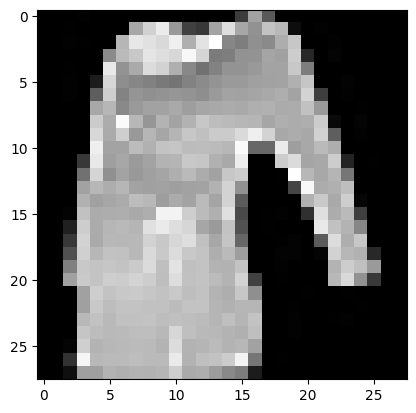

In [13]:
print("b x y c -> ", x.shape)
plt.imshow(x[0,...], cmap="gray");

Text(0, 0.5, 'Density')

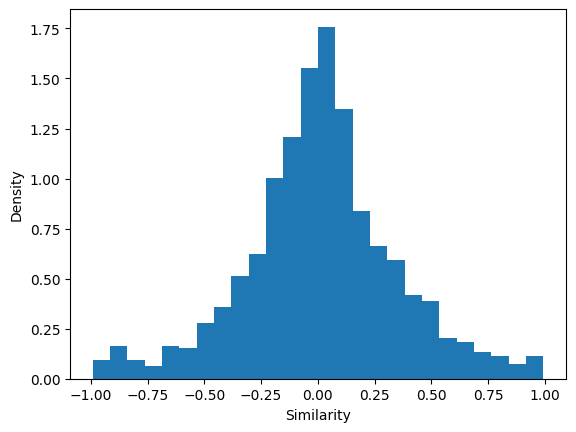

In [14]:
#sample the initial similarities the model produces between an 
# image and the class codebook. 

pred = model.apply(params, key, x)

plt.hist(np.array(pred.ravel()), bins=26, density=True)
plt.xlabel("Similarity")
plt.ylabel("Density")

Text(0, 0.5, 'Density')

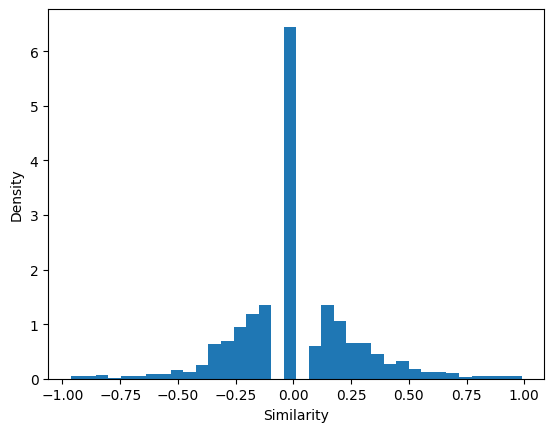

In [19]:
#sample the initial similarities the model produces between an 
# image and the class codebook. 

pred = model.apply(params, key, x, mask_angle = 0.10)

plt.hist(np.array(pred.ravel()), bins=36, density=True)
plt.xlabel("Similarity")
plt.ylabel("Density")

Text(0.5, 1.0, 'Pre-Train Similarity')

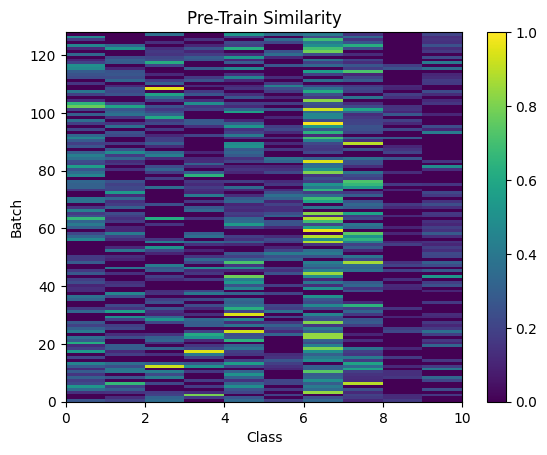

In [23]:
#Visualize the similarity each sample produces to the class codebook
plt.pcolor(jnp.abs(pred), vmax=1.0, vmin=0.0)
plt.xlabel("Class")
plt.ylabel("Batch")
plt.colorbar()
plt.title("Pre-Train Similarity")

In [25]:
loss_fn = lambda yh, y: quadrature_loss(yh, y, num_classes=10)

In [26]:
# Compute a sample of the loss function over these similarities. 
# Takes the complement of the similarity for the correct class label.
# This value (distance) will be minimized over training.

jnp.mean(loss_fn(pred, y))

DeviceArray(0.34420824, dtype=float32)

# Training

In [29]:
mask_angles = np.linspace(0.0, 0.15, 16)

In [30]:
mask_angles

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15])

In [31]:
train_fn = lambda x: train_model(model, 
                               key, 
                               params = params, 
                               dataset = train, 
                               optimizer = opt, 
                               loss_fn = loss_fn, 
                               batches = 1000,
                               mask_angle = x)

results = list(map(train_fn, mask_angles))

100%|██████████| 1000/1000 [00:31<00:00, 31.43it/s]


In [33]:
all_losses = np.stack([r[1] for r in results])

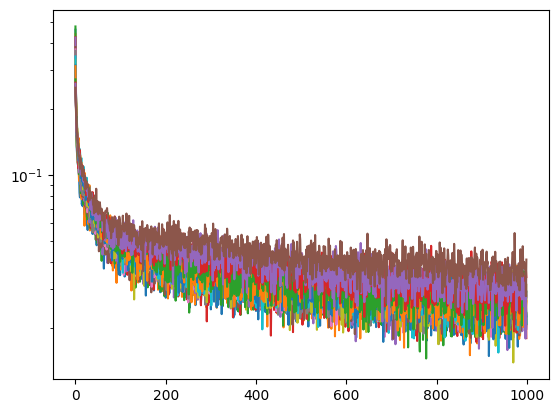

In [53]:
plt.semilogy(all_losses.transpose());

# Test

In [37]:
#Load the testing dataset
test_ds, x_test, y_test = load_dataset(dataset, split="test", is_training=False, repeat = False, batch_size=n_batch)
test = iter(test_ds)

In [75]:
#define a labmda to compute accuracy we can dispatch over batches
acc_fn = lambda p, ma, b: accuracy_quadrature(model, key, p, b['image'], b['label'], mask_angle = ma)
acc_fn_spk = lambda p, ma, b: accuracy_quadrature(model, key, p, b['image'], b['label'], mask_angle = ma, spiking=True)

Compute accuracy across mask angles

In [76]:
eval_fn = lambda i: jnp.mean(jnp.concatenate([acc_fn(results[i][0], mask_angles[i], b) for b in iter(test_ds)]))

In [77]:
all_accs = np.array([eval_fn(i) for i in range(len(results))])

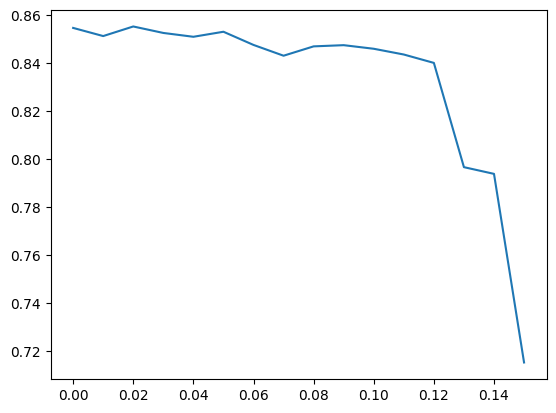

In [78]:
plt.plot(mask_angles, all_accs)

Compute sparsity across mask angles

In [66]:
comp_sparsity = lambda p, ma, ds: jnp.mean(jnp.concatenate([model.apply(p, key, b['image'], mask_angle = ma) == 0.0 for b in iter(ds)]))

In [68]:
sparsities = np.array([comp_sparsity(results[i][0], mask_angles[i], test_ds) for i in range(len(mask_angles))])

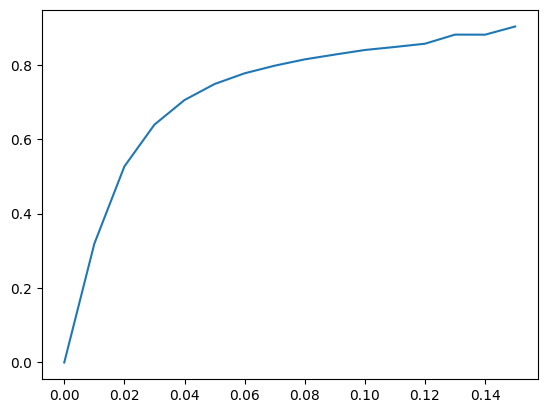

In [70]:
plt.plot(mask_angles, sparsities)

In [82]:
spk_acc_fn = lambda p, ma: accuracy_quadrature(model, key, p, x, y, mask_angle=ma, spiking=True)

In [83]:
spk_accs = [spk_acc_fn(results[i][0], mask_angles[i]) for i in range(len(mask_angles))]

Solving layer phasor_dense


100%|██████████| 1001/1001 [00:02<00:00, 493.18it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 3410.88it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 545.45it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4318.19it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 539.81it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4774.37it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 577.75it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4733.68it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 583.32it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4794.43it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 572.34it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4735.79it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 650.13it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4804.85it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 555.89it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4808.99it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 578.52it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4653.63it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 632.21it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4715.44it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 565.97it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4733.56it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 580.19it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4660.38it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 638.90it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4785.92it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 549.90it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4727.72it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 633.40it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4772.30it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 690.31it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4773.62it/s]


In [91]:
mean_accuracies = np.array([jnp.mean(spk_accs[i], axis=1) for i in range(len(mask_angles))])

In [92]:
mean_accuracies.shape

(16, 11)

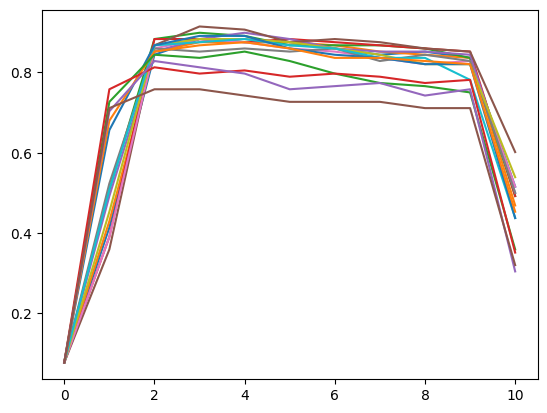

In [95]:
plt.plot(mean_accuracies.transpose());